https://auto.gluon.ai/stable/tutorials/timeseries/forecasting-chronos.html

In [1]:
import os
import pandas as pd
from autogluon.timeseries import TimeSeriesDataFrame, TimeSeriesPredictor

home = os.environ['HOME']


In [2]:
def load_df_from_db(file: str, query: str) -> pd.DataFrame:
    import sqlite3 
    
    conn = sqlite3.connect(file)
    df = pd.read_sql_query(query, conn)
    df['timestamp'] = pd.to_datetime(df['tstamp'])
    df.set_index('timestamp', inplace=True)
    return df


In [7]:
file_path = "/workspace/data/crypto_md/20240601.mktdata.ohlcv.db"
instrument_id='PAIR-BTC-USDT'
query = f"select '{instrument_id}' as id, tstamp, vwap from bnbspot_ohlcv_1min where instrument_id = '{instrument_id}'"
df = load_df_from_db(file=file_path, query=query)
df.rename(columns={'vwap': 'target'}, inplace=True)
# df["tstamp2"] = df.index
df = df.reset_index()
df = df.drop(["timestamp"], axis=1) 
df

id               tstamp        target
0     PAIR-BTC-USDT  1717200000000000000  67566.835981
1     PAIR-BTC-USDT  1717200060000000000  67575.014916
2     PAIR-BTC-USDT  1717200120000000000  67572.550101
3     PAIR-BTC-USDT  1717200180000000000  67600.476125
4     PAIR-BTC-USDT  1717200240000000000  67636.363585
...             ...                  ...           ...
1435  PAIR-BTC-USDT  1717286100000000000  67753.782261
1436  PAIR-BTC-USDT  1717286160000000000  67755.991209
1437  PAIR-BTC-USDT  1717286220000000000  67755.991295
1438  PAIR-BTC-USDT  1717286280000000000  67763.063589
1439  PAIR-BTC-USDT  1717286340000000000  67768.060160

[1440 rows x 3 columns]

In [9]:
data = TimeSeriesDataFrame.from_data_frame(
    df,
    id_column="id",
    timestamp_column="tstamp"
)
data.head()


target
item_id       timestamp                        
PAIR-BTC-USDT 2024-06-01 00:00:00  67566.835981
              2024-06-01 00:01:00  67575.014916
              2024-06-01 00:02:00  67572.550101
              2024-06-01 00:03:00  67600.476125
              2024-06-01 00:04:00  67636.363585

In [12]:
prediction_length = 10
train_data, test_data = data.train_test_split(prediction_length)

predictor = TimeSeriesPredictor(prediction_length=prediction_length).fit(
    train_data, presets="chronos_small",
)


Beginning AutoGluon training...
AutoGluon will save models to 'AutogluonModels/ag-20240606_225207'
=================== System Info ===================
AutoGluon Version:  1.1.0
Python Version:     3.10.13
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #117-Ubuntu SMP Fri Apr 26 12:26:49 UTC 2024
CPU Count:          8
GPU Count:          1
Memory Avail:       54.82 GB / 62.72 GB (87.4%)
Disk Space Avail:   429.42 GB / 476.94 GB (90.0%)
Setting presets to: chronos_small

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': WQL,
 'hyperparameters': {'Chronos': {'model_path': 'small'}},
 'known_covariates_names': [],
 'num_val_windows': 1,
 'prediction_length': 10,
 'quantile_levels': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
 'random_seed': 123,
 'refit_every_n_windows': 1,
 'refit_full': False,
 'skip_model_selection': True,
 'target': 'target',
 'verbosity': 2}

Inferred time series frequency: 'min'
Provided train_data has 1430 rows, 1 time se

Model not specified in predict, will default to the model with the best validation score: Chronos[small]


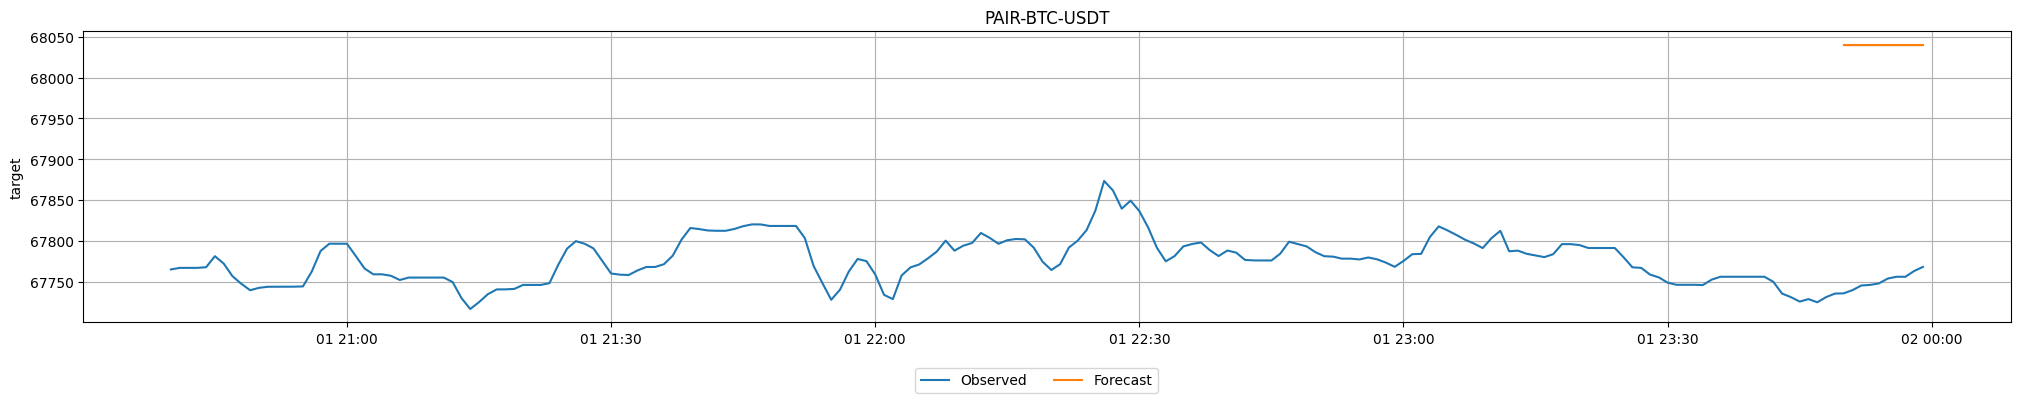

In [13]:
predictions = predictor.predict(train_data)
predictor.plot(
    data=data, 
    predictions=predictions, 
    max_history_length=200,
)